# Accessing TensorBoard Data as DataFrames

## Overview

The main feature of TensorBoard is its interactive GUI. However, users sometimes want to **programmatically** read the data logs stored in TensorBoard, for purposes such as performing post-hoc analyses and creating custom visualizations of the log data.

TensorBoard 2.3 supports this use case with `tensorboard.data.experimental.ExperimentFromDev()`. It allows programmatic access to TensorBoard's [scalar logs](https://www.tensorflow.org/tensorboard/scalars_and_keras). This page demonstrates the basic usage of this new API.

## Setup

In order to use the programmatic API, make sure you install `pandas` alongside `tensorboard`.

We'll use `matplotlib` and `seaborn` for custom plots in this guide, but you can choose your preferred tool to analyze and visualize `DataFrames`.

In [1]:
!pip install tensorboard pandas
!pip install matplotlib seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 710.0 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 1.4 MB/s eta 0:00:00m eta 0:00:010:00:01m
  Attempting uninstall: numpy
    Found existing installation: numpy 1.17.0
    Uninstalling numpy-1.17.0:
      Successfully uninstalled numpy-1.17.0
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 KB 347.8 kB/s eta 0:00:001m255.6 kB/s eta 0:00:01


In [2]:
from packaging import version

import pandas as pd
import seaborn as sns
import tensorboard as tb
from matplotlib import pyplot as plt
from scipy import stats


In [3]:
major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    "This notebook requires TensorBoard 2.3 or later."
print("TensorBoard version: ", tb.__version__)


TensorBoard version:  2.8.0


## Loading TensorBoard scalars as a pandas.DataFrame

Once a TensorBoard logdir has been uploaded to [TensorBoard.dev](https://blog.tensorflow.org/2019/12/introducing-tensorboarddev-new-way-to.html?hl=es-419), it becomes what we refer to as an *experiment*. Each experiment has a unique ID, which can be found in the TensorBoard.dev URL of the experiment. For our demonstration below, we will use a TensorBoard.dev experiment at: https://tensorboard.dev/experiment/gKBxh0ndQvqyLjQgBWvgkA/

In [17]:
experiment_id = "gKBxh0ndQvqyLjQgBWvgkA"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
df


,run,tag,step,value
0,.,global_step/sec,5,1.028818
1,.,global_step/sec,9,1.710624
2,.,global_step/sec,13,1.604946
3,.,global_step/sec,17,1.670286
4,.,global_step/sec,21,1.621521
...,...,...,...,...
86,.,total_cost,73,0.000113
87,.,total_cost,77,0.000093
88,.,total_cost,81,0.000254
89,.,total_cost,85,0.000160


`df` is a [`pandas.DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) that contains all scalar logs of the experiment.

The columns of the `DataFrame` are:

* `run`: each run corresponds to a subdirectory of the original logdir.

* `tag`: this describes what the `value` in the same row means, that is, what metric the value represents in the row. In this experiment, we have four tags:
    * `global_step/sec` is the iteration (so global_step 50 means we're processing the 50th batch) by seconds.
    * `regularization_cost` 
    * `task_cost`
    * `total_cost`


* `step`: This is a number that reflects the serial order of the corresponding row in its run. Here `step` actually refers to epoch number. If you wish to obtain the timestamps in addition to the `step` values, you can use the keyword argument `include_wall_time=True` when calling `get_scalars()`.

* `value`: This is the actual numerical value of interest. As described above, each `value` in this particular `DataFrame` is either a loss or an accuracy, depending on the `tag` of the row.


In [19]:
print(df["tag"].unique())


['global_step/sec' 'regularization_cost' 'task_cost' 'total_cost']


## Saving the DataFrame as CSV

`pandas.DataFrame` has good interoperability with [CSV](https://en.wikipedia.org/wiki/Comma-separated_values). You can store it as a local CSV file and load it back later. For example:

In [22]:
csv_path = '/tmp/tb_experiment_1.csv'
df.to_csv(csv_path, index=False)
df_roundtrip = pd.read_csv(csv_path)
pd.testing.assert_frame_equal(df_roundtrip, df)


## Performing custom visualization and statistical analysis

In [26]:
# Filter the DataFrame to only validation data, which is what the subsequent
# analyses and visualization will be focused on.
df_validation = df[df.run.str.endswith("/validation")]
# Get the optimizer value for each row of the validation DataFrame.
optimizer_validation = df_validation.run.apply(lambda run: run.split(",")[0])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=df_validation, x="step", y="global_step/sec",
             hue=optimizer_validation).set_title("global_step/sec")
plt.subplot(1, 2, 2)
sns.lineplot(data=df_validation, x="step", y="regularization_cost",
             hue=optimizer_validation).set_title("regularization_cost")
plt.show()

ValueError: Could not interpret value `global_step/sec` for parameter `y`

The plots above show the timecourses of validation accuracy and validation loss. Each curve shows the average across 5 runs under an optimizer type. Thanks to a built-in feature of `seaborn.lineplot()`, each curve also displays ±1 standard deviation around the mean, which gives us a clear sense of the variability in these curves and the significance of the differences among the three optimizer types. This visualization of variability is not yet supported in TensorBoard's GUI.

We want to study the hypothesis that the minimum validation loss differs significantly beteen the "adam", "rmsprop" and "sgd" optimizers. So we extract a DataFrame for the minimum validation loss under each of the optimizers.

Then we make a boxplot to visualize the difference in the minimum validation losses.

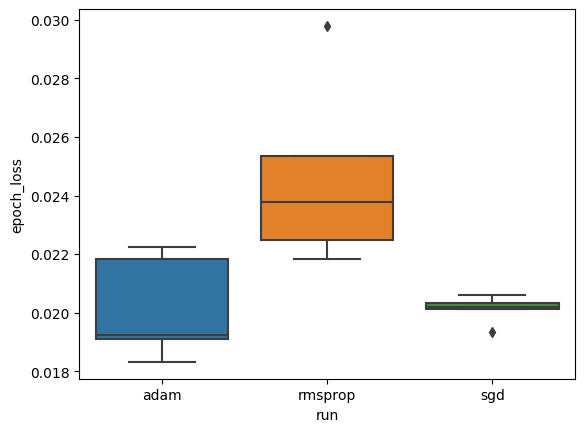

In [15]:
adam_min_val_loss = df_validation.loc[optimizer_validation=="adam", :].groupby(
    "run", as_index=False).agg({"epoch_loss": "min"})
rmsprop_min_val_loss = df_validation.loc[optimizer_validation=="rmsprop", :].groupby(
    "run", as_index=False).agg({"epoch_loss": "min"})
sgd_min_val_loss = df_validation.loc[optimizer_validation=="sgd", :].groupby(
    "run", as_index=False).agg({"epoch_loss": "min"})
min_val_loss = pd.concat([adam_min_val_loss, rmsprop_min_val_loss, sgd_min_val_loss])

sns.boxplot(data=min_val_loss, y="epoch_loss",
            x=min_val_loss.run.apply(lambda run: run.split(",")[0]))
plt.show()

In [16]:
# Perform pairwise comparisons between the minimum validation losses
# from the three optimizers.
_, p_adam_vs_rmsprop = stats.ttest_ind(
    adam_min_val_loss["epoch_loss"],
    rmsprop_min_val_loss["epoch_loss"]) 
_, p_adam_vs_sgd = stats.ttest_ind(
    adam_min_val_loss["epoch_loss"],
    sgd_min_val_loss["epoch_loss"]) 
_, p_rmsprop_vs_sgd = stats.ttest_ind(
    rmsprop_min_val_loss["epoch_loss"],
    sgd_min_val_loss["epoch_loss"]) 
print("adam vs. rmsprop: p = %.4f" % p_adam_vs_rmsprop)
print("adam vs. sgd: p = %.4f" % p_adam_vs_sgd)
print("rmsprop vs. sgd: p = %.4f" % p_rmsprop_vs_sgd)


adam vs. rmsprop: p = 0.0244
adam vs. sgd: p = 0.9749
rmsprop vs. sgd: p = 0.0135


Therefore, at a significance level of 0.05, our analysis confirms our hypothesis that the minimum validation loss is significantly higher (i.e., worse) in the rmsprop optimizer compared to the other two optimizers included in our experiment.

In summary, this tutorial provides an example of how to access scalar data as `panda.DataFrames` from TensorBoard.dev. It demonstrates the kind of flexible and powerful analyses and visualization you can do with the `DataFrame`s.